In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, dblquad

%config InlineBackend.figure_format = 'retina'

fontsize = 15

plt.rcParams.update({

    'figure.figsize': (9,6),

    # font
    'text.usetex': True,
    'font.family': 'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'figure.titlesize' : fontsize+1,

    # axes
    'axes.labelsize': fontsize-1,
    'axes.titlesize': fontsize,
    #'axes.linewidth': 2,
    'axes.axisbelow': True,
    'axes.grid': True,
    'grid.alpha': 0.5,

    # ticks
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    #'xtick.direction': 'in',
    #'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,    
    #'xtick.major.pad': 8,

    # legend
    'legend.fontsize': fontsize-1,

    # plots
    #'lines.linewidth': 1.6,
    #'scatter.marker': 'o',
    #'lines.markersize': 8,
    #'scatter.edgecolors': 'black'
})

# Advanced Gravitational Physics ~ Cosmology exercises

Tommmaso Peritore 67043A

In [3]:
## COSMOLOGICAL PARAMETERS ##

H0 = 68                                 # km/(s*Mpc) Hubble constant
h = H0 / 100                            # dimensionless Hubble parameter
T0 = 2.7                                # K Radiation temperature
c = 299792.458                          # km/s Speed of light
G = 6.67430e-20                         # km^3/(kg*s^2) Gravitational constant
sigma_SB = 5.670374e-8                  # kg/(s^3*K^4) Stefan-Boltzmann constant
Neff = 3.046                            # Effective number of neutrino species

Mpc_in_km = 3.08567758e19               # km/Mpc conversion factor
H0_per_sec = H0 / Mpc_in_km             # Convert H0 to 1/s

rhoc = 3*H0_per_sec**2 / (8*np.pi*G)    # Critical density in kg/km^3
rhog = 4*sigma_SB * T0**4 / c**3        # Radiation density in kg/km^3
OmG = rhog / rhoc                        # Photon density parameter

OmM = 0.3                                # Matter density parameter
OmR = OmG * (1 + 7/8*(4/11)**(4/3)*Neff) # Radiation density parameter
OmL = 1 - OmR - OmM                      # Cosmological constant density parameter

pref = 1.5 * OmM * (H0/c)**2             # Lensing kernel prefactor

In [4]:
## DATA LOADING AND INTERPOLATION ##

# Load the input power spectrum at z=0
k, P_k = np.loadtxt('test_lcdm_z0_pk.dat', unpack=True, usecols=(0,1))

k_in = k * h                             # Convert k from h/Mpc to 1/Mpc
P_in = P_k / h**3                        # Convert P(k) from (Mpc/h)^3 to Mpc^3

# Interpolation is needed to evaluate P(k) at arbitrary k values during the integration
Pk_interp = interp1d(np.log(k_in), np.log(P_in), kind='cubic', bounds_error=False, fill_value="extrapolate")

# Define CMB redshift 
z_recomb = 1089.0

In [5]:
## COSMOLOGICAL FUNCTIONS ##

# Hubble E(z) = H(z)/H0
E = lambda z : np.sqrt(OmM*(1+z)**3 + OmR*(1+z)**4 + OmL) # Computes Hubble parameter at redshift z in km/s/Mpc
H = lambda z : H0 * E(z) # Computes Hubble parameter at redshift z in km/s/Mpc

# Comoving distance chi(z)
chi_z = lambda z: quad(lambda zp: c/H(zp), 0, z)[0]
chi_s = chi_z(z_recomb) # Comoving distance to the CMB

# Lensing kernel 
gL = lambda z: 1 - chi_z(z)/chi_s

# Integral function of growth factor D(z)
growth_integ_f = lambda z : (1+z)/ H(z)**3

# precompute growth factor at z=0 for normalization
z_lim = 5000 # integrate to effectively infinity: z=5000 covers radiation era well enough
integ_0 = quad(growth_integ_f, 0, z_lim)[0] 
D0_norm = E(0) * integ_0

# Growth factor D(z) normalized to D(0)=1
def D(z):
    # integrate from z to infty
    integ_z = quad(growth_integ_f, z, z_lim)[0] # large enough number  
    return E(z) * integ_z / D0_norm

# Power spectrum at redshift z
get_P_k = lambda k, z : np.exp(Pk_interp(np.log(k))) * D(z)**2

# plt.loglog(k, P_k, label=r'$P(k,z=0)$ input')
# plt.loglog(k_in, get_P_k(k_in, z_source), label=f'$P(k,z={z_source})$ interpol', linestyle='--')
# plt.loglog(k_in, get_P_k(k_in, z_recomb), label=f'$P(k,z={z_recomb})$ interpol', linestyle='-.')
# plt.xlabel(r'$k$ [1/Mpc]')
# plt.ylabel(r'$P(k)$ [Mpc$^3$]')
# plt.legend()
# plt.grid(True, which='both', alpha=0.3)
# plt.show()

In [6]:
## DEPRECATED -- INTEGRATION FOR C_kk up to z=1.5 ##

# Integrand for C_kk integral
# def Ckk_int_f (z, l) :
#     chi = chi_z(z)
#     if chi <= 1e-5: return 0.0  # Avoid division by zero at z=0
# 
#     jacobian = c / H(z)         # Jacobian for dz -> dchi
#     k = l / chi                 # Limber approximation: k = l/chi
#     P = get_P_k(k, z)           # Evaluate P(k,z) using the interpolated growth factor
# 
#     return jacobian * (pref*(1+z)*gL(z))**2 * P     
# 
# # Integration
# l_values = np.logspace(0, 3.7, 50)      # l values from 1 to ~5000
# C_kk = []
# 
# for l in l_values:
#     # Integrate from 0 to z_source
#     val, err = quad(Ckk_int_f, 0, z_source, args=(l,))
#     C_kk.append(val)
# 
# C_kk = np.array(C_kk)
# 
# # Plot
# plt.loglog(l_values, l_values*(l_values+1)*C_kk/(2*np.pi), label=f'Linear $z_s={z_source}$')
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'$\ell(\ell+1)C_{\kappa\kappa}(\ell)/2\pi$')
# plt.grid(True, which='both', alpha=0.3)
# plt.legend()
# plt.show()

/var/folders/n2/1fm5mmdn64z6dgwv0dmjpn7r0000gn/T/ipykernel_18972/4175444729.py:25: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integ_z = quad(growth_integ_f, z, z_lim)[0] # large enough number
/var/folders/n2/1fm5mmdn64z6dgwv0dmjpn7r0000gn/T/ipykernel_18972/2589728276.py:20: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, _ = quad(Ck_int_f, 0, z_recomb, args=(l,), limit=100)


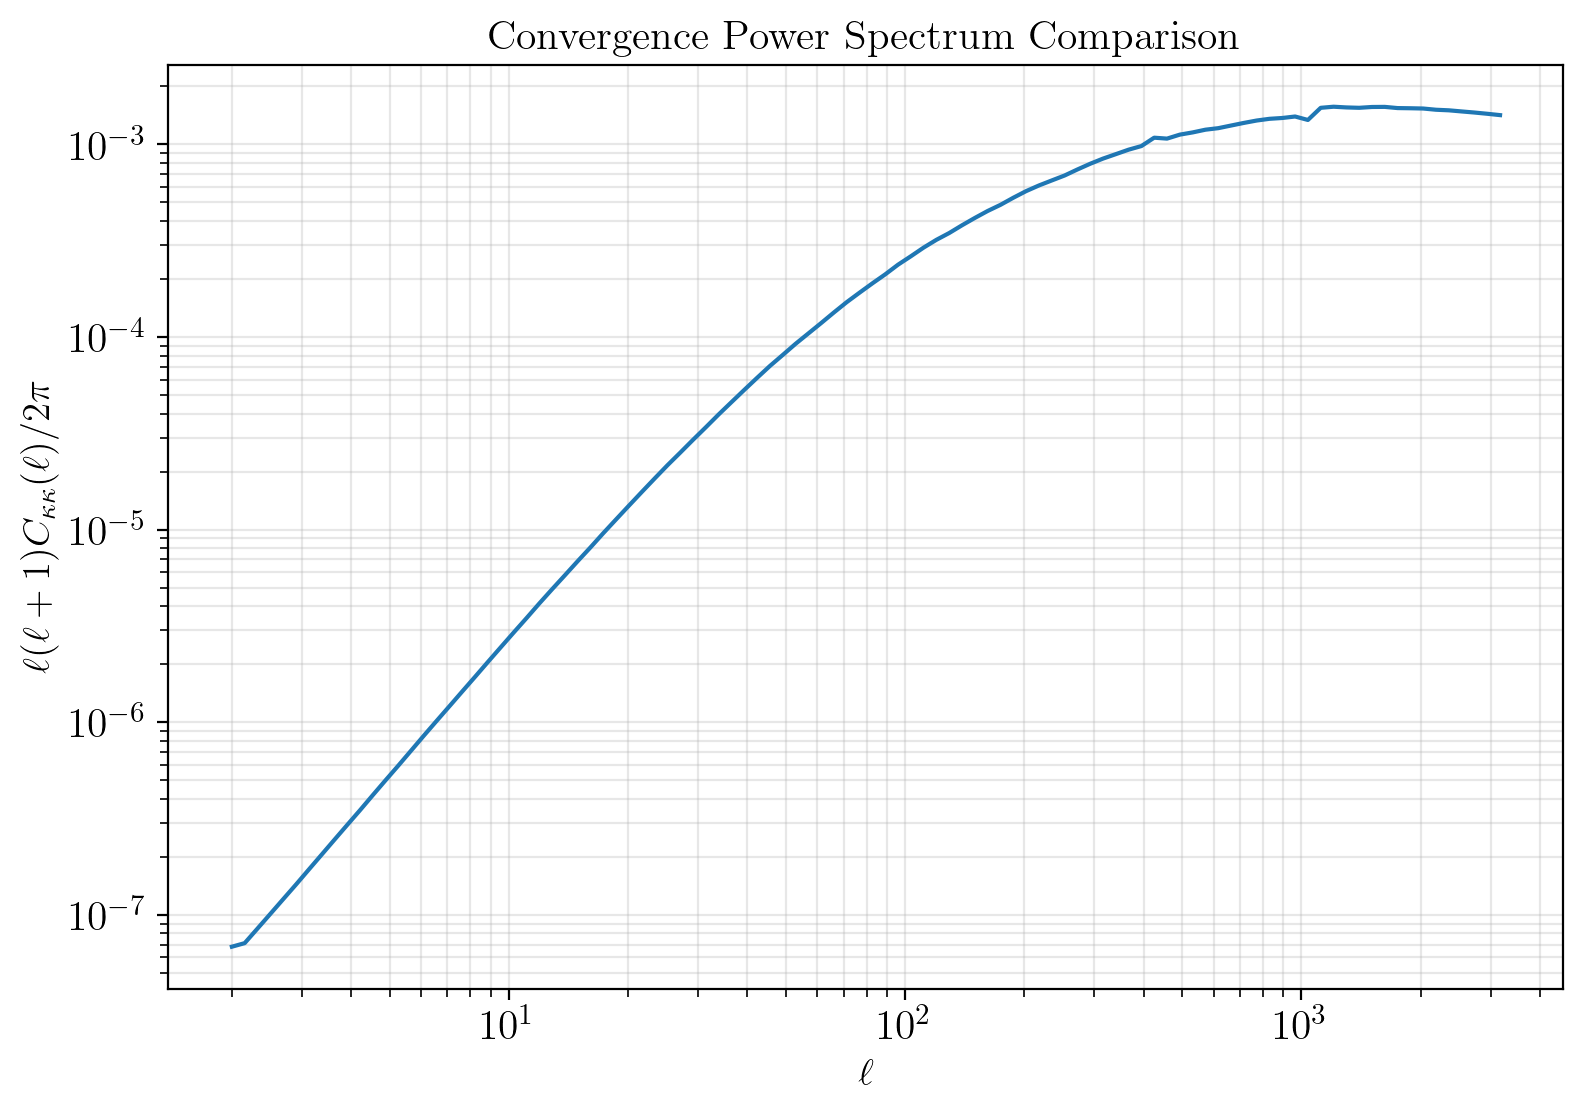

In [7]:
## INTEGRATION TO CMB RECOMBINATION SOURCE ##

def Ck_int_f(z, l):
    chi = chi_z(z)
    if chi <= 1e-5: return 0.0
    
    jacobian = c / H(z)         # Jacobian for dz -> dchi
    k_limber = l / chi          # Limber approximation: k = l/chi
    P = get_P_k(k_limber, z)           # Evaluate P(k,z) w/ interpolated growth factor
    
    # Integrand = A^2 * (dchi/dz) * [(1+z) * gL(z)]^2 * P(k)
    return jacobian * (pref*(1+z)*gL(z))**2 * P
        
# Integration for both sources

l_values = 2*np.logspace(0, 3.2, 100)
Ckk = []

for l in l_values:
    val, _ = quad(Ck_int_f, 0, z_recomb, args=(l,), limit=100)
    Ckk.append(val)
    

# Plotting
plt.loglog(l_values, l_values*(l_values+1)*Ckk/(2*np.pi))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\kappa\kappa}(\ell)/2\pi$')
plt.title(r'Convergence Power Spectrum Comparison')
plt.grid(True, which='both', alpha=0.3)
plt.show()

## Temperature Spectrum

We want to evaluate the lensed temperature spectrum, using Dodelson's Eq.13.21, i.e.
$$
\begin{align}
C^{\text{obs}}(l) &= C(l) + C^{(22)}(l) + 2C^{(13)}(l) \\
C^{(22)}(l) &= \int \frac{d^2l_1}{(2\pi)^2} \left[ \boldsymbol{l}_1 \cdot (\boldsymbol{l} - \boldsymbol{l}_1) \right]^2 C_{\phi_{\text{L}}\phi_{\text{L}}}(l_1) C(|\boldsymbol{l} - \boldsymbol{l}_1|) \\
C^{(13)}(l) &= -\frac{1}{4} \left[ \int \frac{d^2l_1}{(2\pi)^2} l_1^2 C_{\phi_{\text{L}}\phi_{\text{L}}}(l_1) \right] l^2 C(l)
\end{align}
$$
Here the $C(l)$ is in this case the temperature autocorrelation spectrum $C_{TT} (l)$ and so $C^{\text{obs}}(l)$ is the lensed temperature spectrum we observe now.

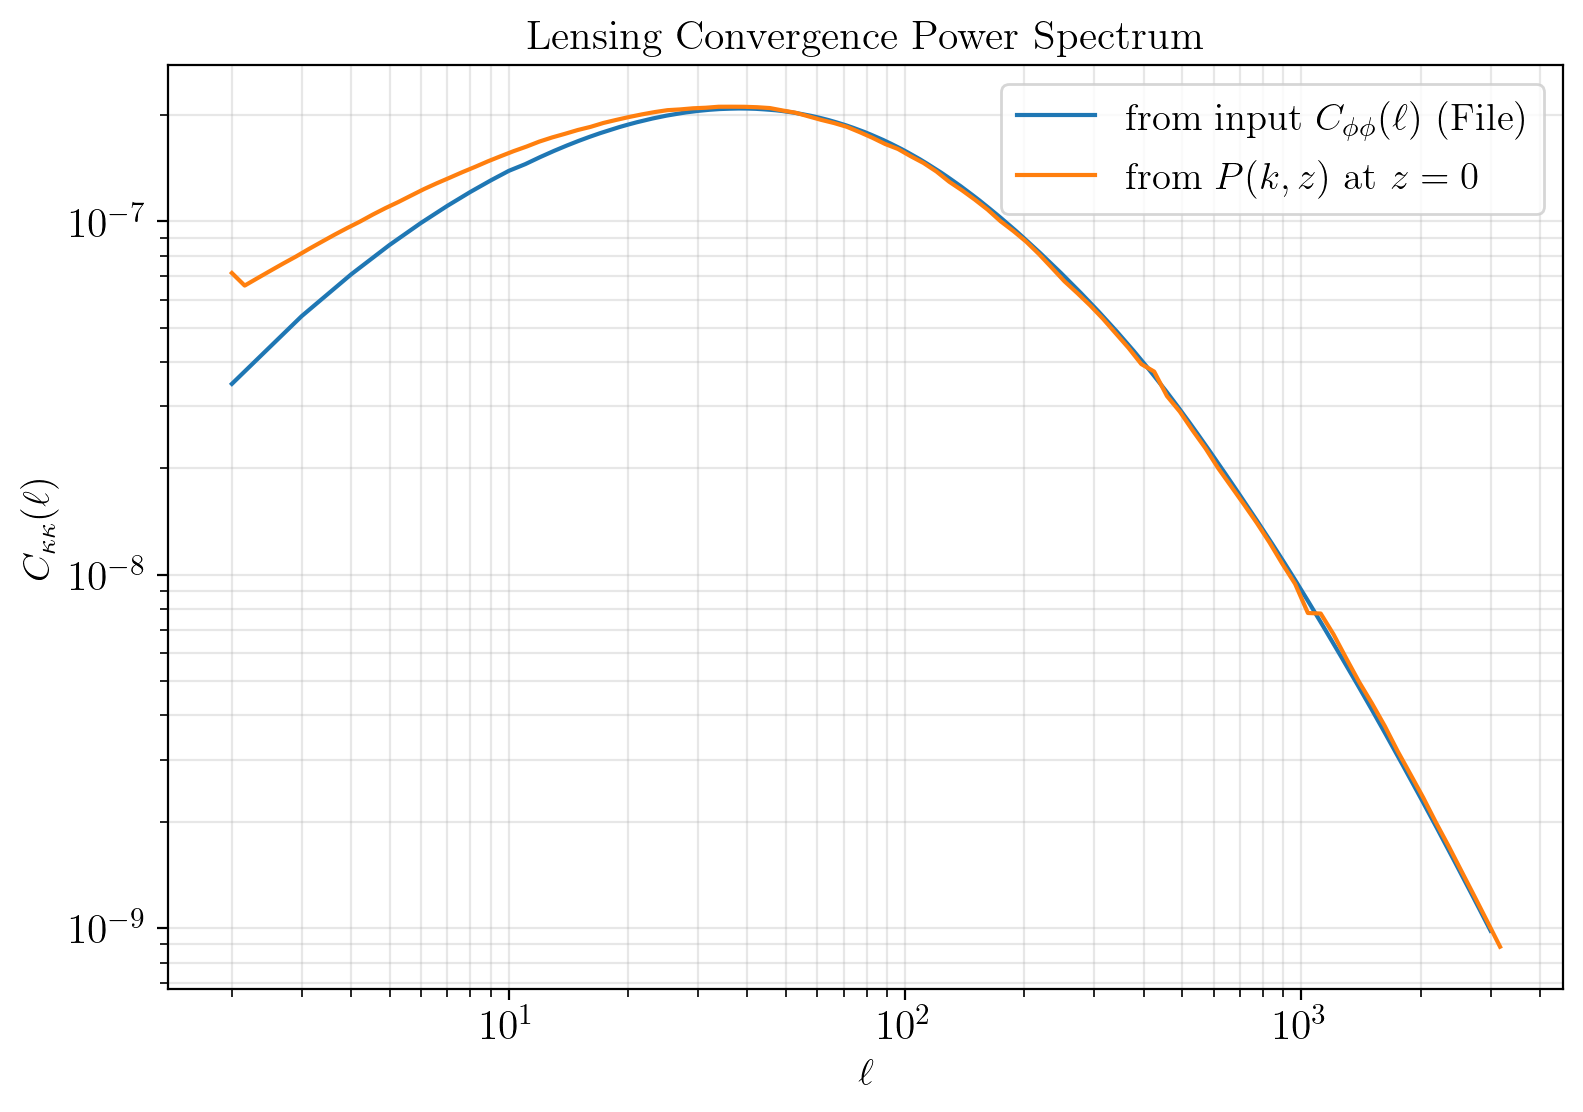

Sigma squared: 4.5953e-07
Starting Vectorized Calculation for 500 multipoles...
l=1.0065e+02 | Unlensed: 2.24e-13 | C22: 7.23e-16 | 2*C13: -5.22e-16
l=2.0006e+02 | Unlensed: 1.18e-13 | C22: 9.63e-16 | 2*C13: -1.08e-15
l=3.0037e+02 | Unlensed: 3.80e-14 | C22: 7.17e-16 | 2*C13: -7.89e-16
l=2.1004e+03 | Unlensed: 4.10e-17 | C22: 3.96e-17 | 2*C13: -4.15e-17


In [8]:
# Load the Data -> 0:l, 1:TT, 2:EE, 3:TE, 4:BB, 5:phiphi, 6:TPhi, 7:Ephi 
# Note: The file contains D_l = l(l+1)C_l / (2*pi)
data = np.loadtxt('test_lcdm_cl.dat')
l = data[:, 0]
TT_Dl = data[:, 1]      # D_l^TT
EE_Dl = data[:, 2]      # D_l^EE
pp_Dl = data[:, 5]      # D_l^phiphi


# Convert to Raw C_l
# We need raw C_l for the physics integrals (convolution)
# Factor to convert D_l -> C_l: 2*pi / (l*(l+1))
to_Cl = (2 * np.pi) / (l * (l + 1))
Cl_TT = TT_Dl * to_Cl
Cl_EE = EE_Dl * to_Cl
Cl_pp = pp_Dl * to_Cl

# Create Interpolation Functions
CTT_interp = interp1d(l, Cl_TT, kind='linear', bounds_error=False, fill_value=0.0)
CEE_interp = interp1d(l, Cl_EE, kind='linear', bounds_error=False, fill_value=0.0)
Cpp_interp = interp1d(l, Cl_pp, kind='linear', bounds_error=False, fill_value=0.0)

C_kk_from_file = (l**4 / 4.0) * Cl_pp
plt.loglog(l, C_kk_from_file, label=r'from input $C_{\phi\phi}(\ell)$ (File)')
plt.loglog(l_values, Ckk, label=r'from $P(k,z)$ at $z=0$')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\kappa\kappa}(\ell)$')
plt.title(r'Lensing Convergence Power Spectrum')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.show()

# # Preliminary Plot to Check Interpolation
# plt.loglog(l, Cpp_interp(l), label=r'Interpolated $C_{\phi\phi}(\ell)$', linestyle='--')
# # plt.loglog(l, Cl_TT, label=r'Raw $C_{TT}(\ell)$', linestyle=':')
# plt.loglog(l, CTT_interp(l), label=r'Interpolated $C_{TT}(\ell)$', linestyle='-.')
# # plt.loglog(l, Cl_pp, label=r'Raw $C_{\phi\phi}(\ell)$', linestyle=':')
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'$C_{\kappa\kappa}(\ell)$')
# plt.title(r'Lensing Convergence Power Spectrum')
# plt.grid(True, which='both', alpha=0.3)
# plt.legend()
# plt.show()


## LENSING EXPANSION

# C^(13) TERM (Constant Variance)

# The 2*C^(13) term is: -1/2 * [Integral] * l^2 * CTT_interp(l)
# The integral is the variance of the deflection angle:
# Sigma^2 = 1/(2pi) * Integral(l^3 * Cpp_interp(l))

def integ_sigma(l_in):
    return l_in**3 * Cpp_interp(l_in)

# Integrate over the full range of the lens scale (from data)
l_min, l_max = np.min(l), np.max(l)
val_sigma, _ = quad(integ_sigma, l_min, l_max)
sigma_squared = (1.0 / (2 * np.pi)) * val_sigma
print(f"Sigma squared: {sigma_squared:.4e}")

# C^(22) TERM (Convolution)

def get_CTT_22(l):
    """
    Computes C^(22) using a fixed log-grid for l_prime.
    This captures the lensing peak much better than 'quad'.
    """
    # Grids
    l1 = np.logspace(np.log10(l_min), np.log10(l_max), 500)[:, None] # shape: (500, 1) for broadcasting
    theta = np.linspace(0, 2*np.pi, 200)[None, :] # shape: (1, 200) for broadcasting

    # vectorized Geometry |l - l'|; result is 500x200 matrix
    L_mag = np.sqrt(l**2 + l1**2 - 2*l*l1*np.cos(theta))
    
    # coupling Factor: [l' . (l - l')]^2
    coupling = (l1 * l * np.cos(theta) - l1**2)**2
    
    # integrand, broadcasting interpolators
    integrand_2d = coupling * Cpp_interp(l1) * CTT_interp(L_mag)

    # integrate over theta (Axis 1) -> result is (500, 1)
    theta_integrated = np.trapezoid(integrand_2d, theta, axis=1)
    
    # integrate over l1 (Axis 0)
    l1_flat = l1.flatten()
    outer_integrand = l1_flat * theta_integrated # measure l1 from dl1^2 -> l1*dl1dtheta
    
    result = np.trapezoid(outer_integrand, l1_flat) / (2*np.pi)**2
    return result
    
    
# EXECUTION LOOP

#l_calc = np.logspace(np.log10(l_min), np.log10(l_max), 1000) 
l_calc = np.logspace(np.log10(20), np.log10(2500), 500) 

c_unlensed = []
c_lensed = []
c_22 = []
c_13 = []


print(f"Starting Vectorized Calculation for {len(l_calc)} multipoles...")

for l_val in l_calc:
    # 0. Base Spectrum
    cl_0 = CTT_interp(l_val)
    
    # 1. C^(13) Correction: -1/2 * Sigma^2 * l^2 * C_TT
    correction_13 = - 0.5 * sigma_squared * l_val**2 * cl_0
    # 2. C^(22) Correction
    correction_22 = get_CTT_22(l_val)
    
    # Total
    cl_obs = cl_0 + correction_22 + correction_13
    
    c_unlensed.append(cl_0)
    c_lensed.append(cl_obs)
    c_22.append(correction_22)
    c_13.append(correction_13)    

    # Print progress every 10 steps
    if l_val > 10 and int(l_val) % 100 == 0:
        print(f"l={l_val:.4e} | Unlensed: {cl_0:.2e} | C22: {correction_22:.2e} | 2*C13: {correction_13:.2e}")

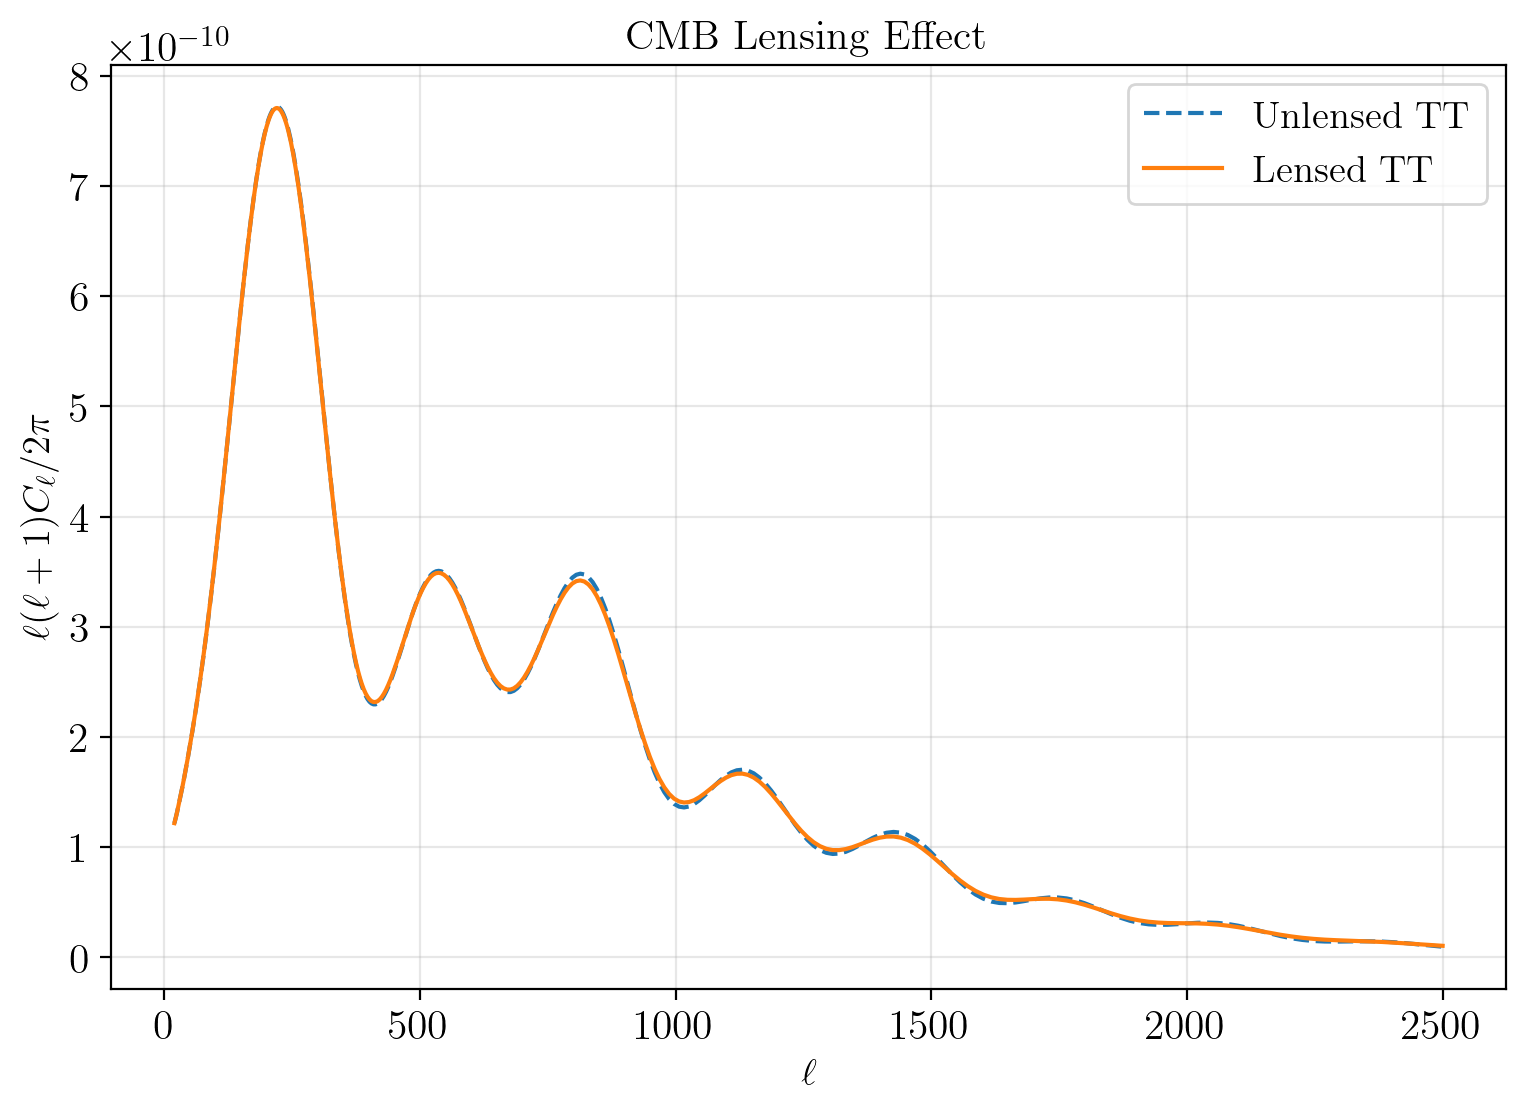

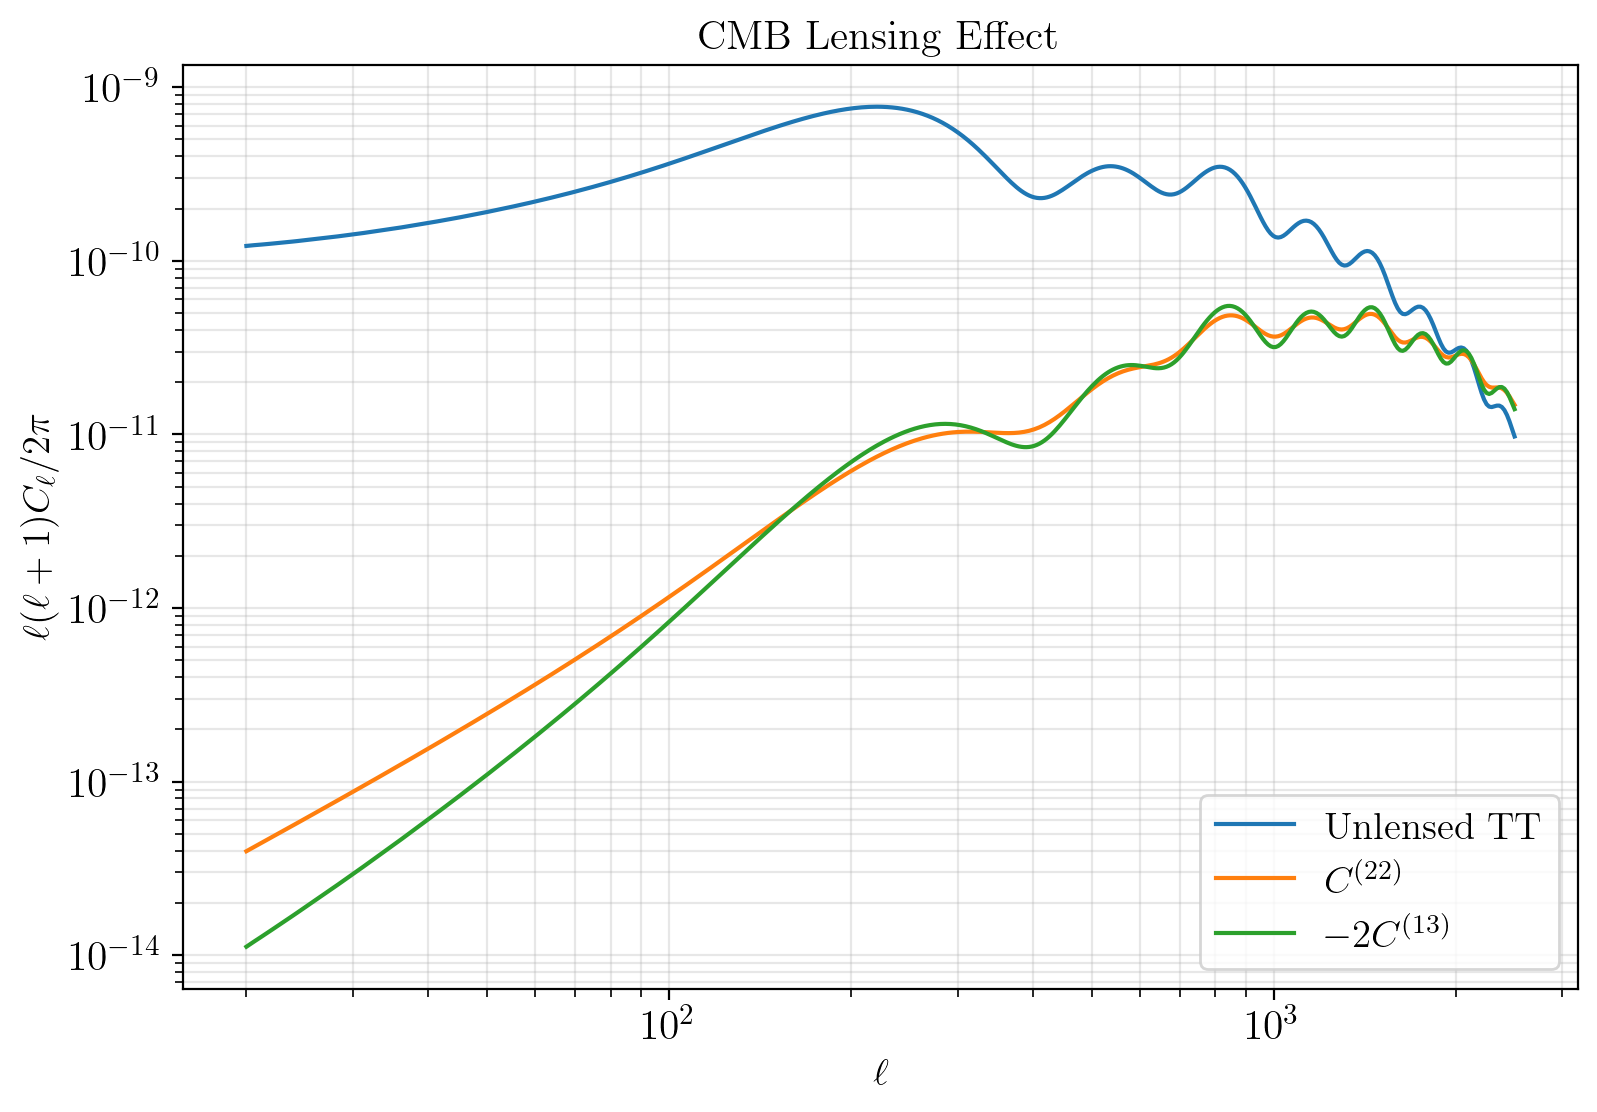

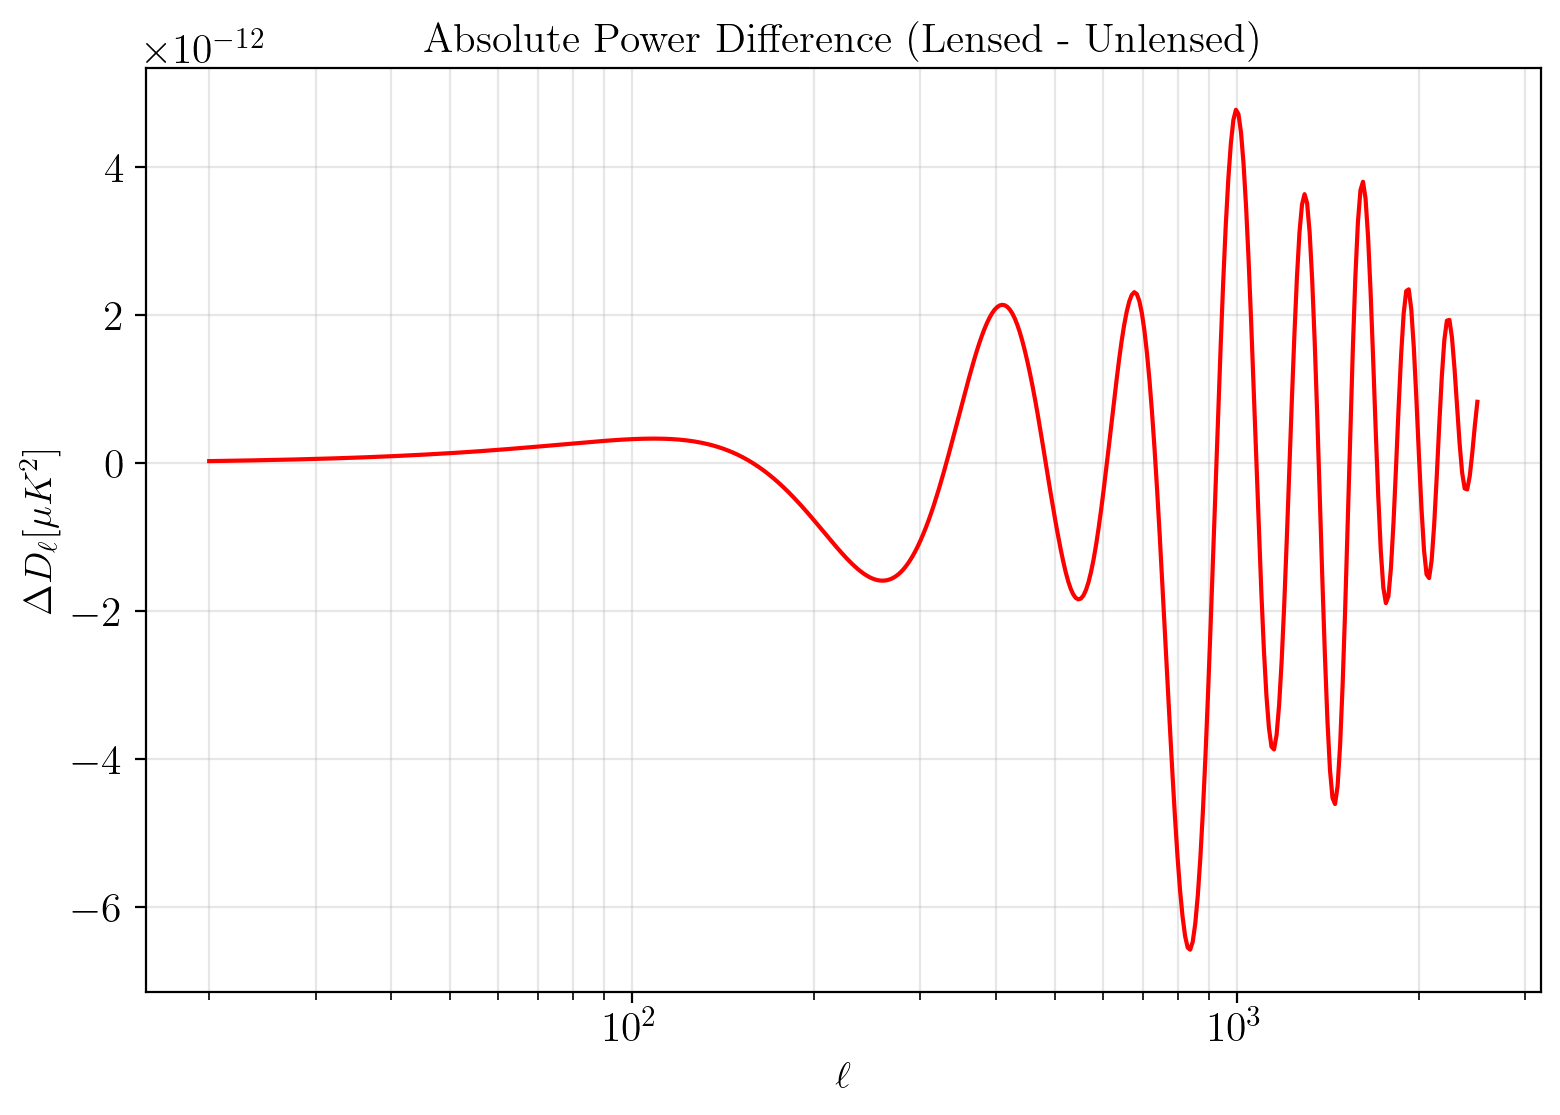

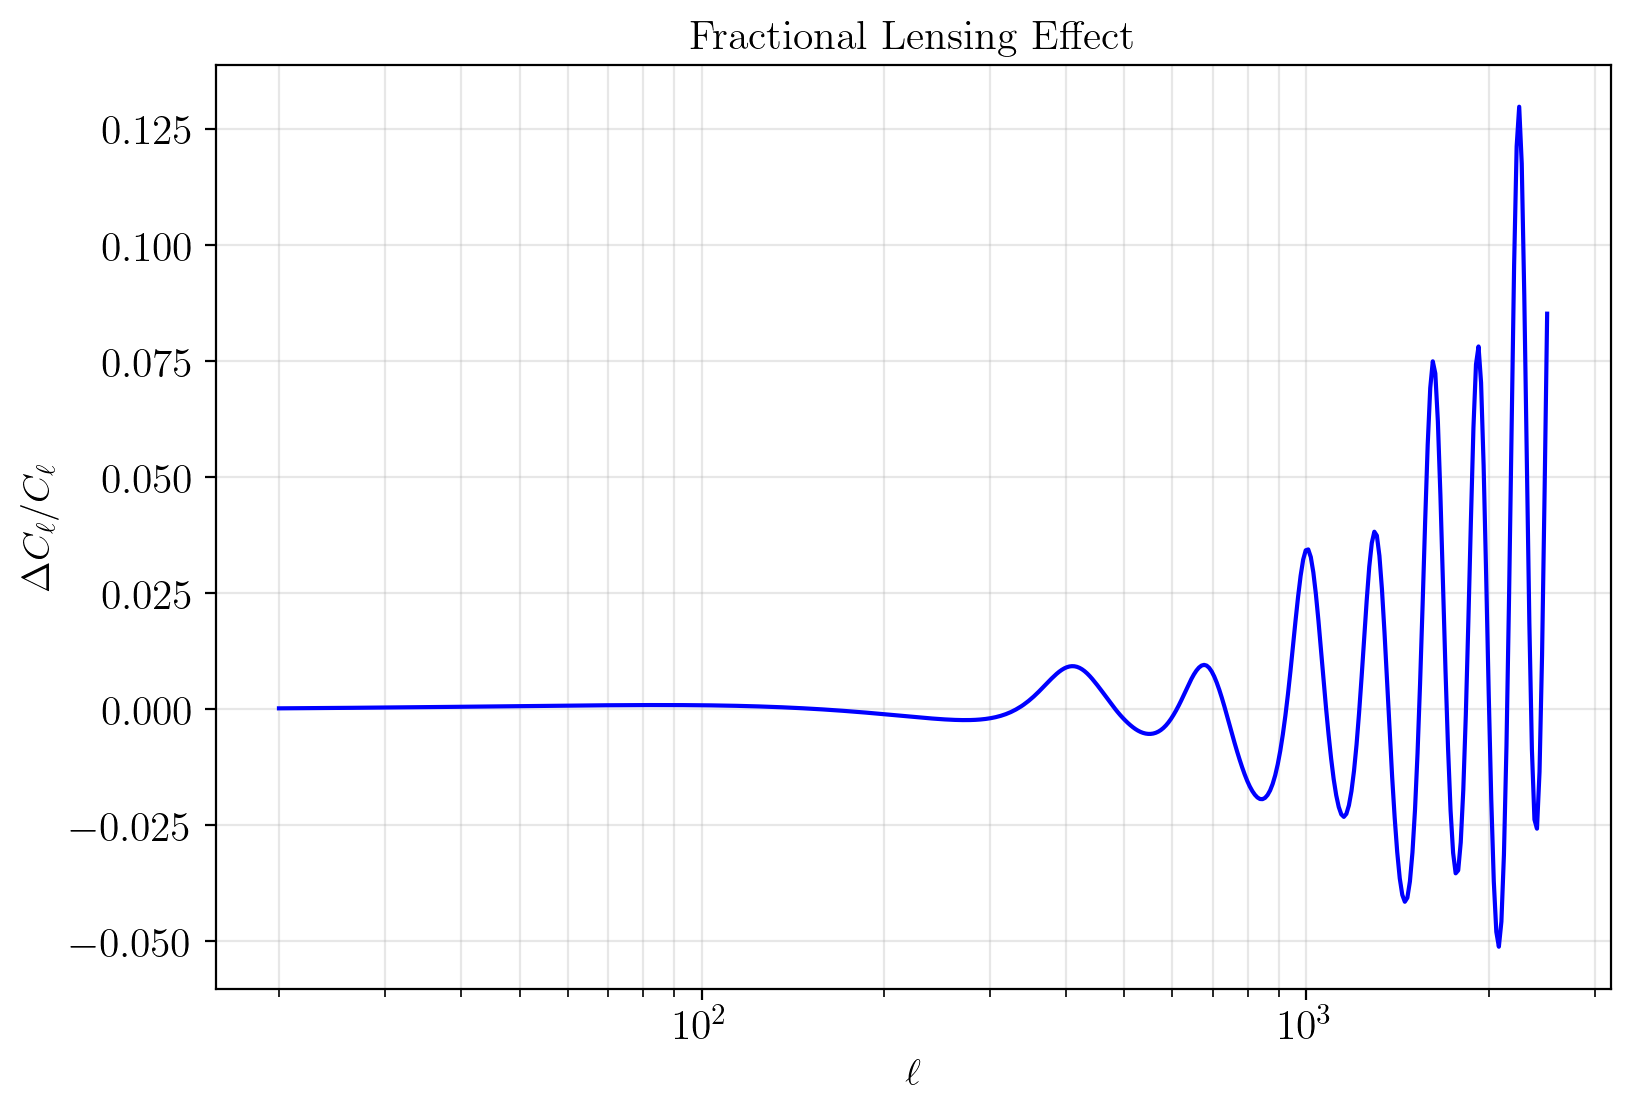

In [9]:
# PLOTTING

c_unlensed = np.array(c_unlensed)
c_lensed = np.array(c_lensed)
c_22 = np.array(c_22)
c_13 = np.array(c_13)
scale = l_calc * (l_calc + 1) / (2 * np.pi)

# Spectra
plt.plot(l_calc, scale * c_unlensed, '--', label='Unlensed TT')
plt.plot(l_calc, scale * c_lensed, '-', label='Lensed TT')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.title('CMB Lensing Effect')
plt.legend()
plt.grid(which='both', alpha=0.3)
plt.show()

# Potential terms
plt.loglog(l_calc, scale * c_unlensed, label='Unlensed TT')
plt.loglog(l_calc, scale * c_22, label=r'$C^{(22)}$')
plt.loglog(l_calc, scale  * -c_13, label=r'$-2C^{(13)}$')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.title('CMB Lensing Effect')
plt.legend()
plt.grid(which='both', alpha=0.3)
plt.show()


# ABSOLUTE Difference (Delta D_l)
abs_diff = scale * (c_lensed - c_unlensed)
plt.semilogx(l_calc, abs_diff, 'r-')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta D_\ell [\mu K^2]$') # Power units
plt.title('Absolute Power Difference (Lensed - Unlensed)')
plt.grid(which='both', alpha=0.3)
plt.show()

# FRACTIONAL Difference (Delta C / C)
frac_diff = (c_lensed - c_unlensed) / c_unlensed
plt.semilogx(l_calc, frac_diff, 'b-')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / C_\ell$') # Dimensionless
plt.title('Fractional Lensing Effect')
plt.grid(which='both', alpha=0.3)
plt.show()

## Polarization

$$ \tilde{C}_{EE}(l) = C_{EE}(l) \left[ 1 - 2\sigma^2 l^2 \right] + \int \frac{d^2l_1}{(2\pi)^2} \left( \mathbf{l}_1 \cdot (\mathbf{l} - \mathbf{l}_1) \right)^2 C_{EE}(|\mathbf{l} - \mathbf{l}_1|) C_{\phi\phi}(l_1) \cos^2 2(\varphi_l - \varphi_{ll_1}) $$
$$ \tilde{C}_{BB}(l) = \int \frac{d^2l_1}{(2\pi)^2} \left( \mathbf{l}_1 \cdot (\mathbf{l} - \mathbf{l}_1) \right)^2 C_{EE}(|\mathbf{l} - \mathbf{l}_1|) C_{\phi\phi}(l_1) \sin^2 2(\varphi_l - \varphi_{ll_1}) $$

In [10]:
# Similarly to the temperature, we can compute the lensing effect on the E-mode polarization spectrum. 
# The procedure is the same, but we use C_EE instead of C_TT in the convolution integrals. 


def get_CEE_22 (mode, l):
    """
    Computes C^(22) for the E-mode polarization using the same vectorized approach as for the temperature.
    """
    # Grids
    l1 = np.logspace(np.log10(l_min), np.log10(l_max), 500)[:, None] # shape: (500, 1) for broadcasting
    theta = np.linspace(0, 2*np.pi, 200)[None, :] # shape: (1, 200) for broadcasting

    # vectorized Geometry |l - l'|; result is 500x200 matrix
    L_mag = np.sqrt(l**2 + l1**2 - 2*l*l1*np.cos(theta))
    
    # coupling Factor: [l' . (l - l')]^2
    coupling = (l1 * l * np.cos(theta) - l1**2)**2

    #phi_ll1 = np.arctan2(-l1 * np.sin(theta), l - l1 * np.cos(theta))
    phi_ll1 = np.arctan(-l1 * np.sin(theta) / (l - l1 * np.cos(theta)))

    if mode=='EE':
        #conv_anglular = (np.cos(2*theta))**2 # for testing, wrong angular dependence
        conv_anglular = (np.cos(2*phi_ll1))**2
    elif mode=='BB':
        #conv_anglular = (np.sin(2*theta))**2 # for testing, wrong angular dependence
        conv_anglular = (np.sin(2*phi_ll1))**2
    elif mode=='check': # EE+BB = cos^2 + sin^2 = 1
        conv_anglular = np.ones_like(phi_ll1) # For checking the convolution without angular dependence
    else:
        raise ValueError("Mode must be 'EE' or 'BB'")

    # integrand, broadcasting interpolators
    integrand_2d = coupling * Cpp_interp(l1) * CEE_interp(L_mag) * conv_anglular

    # integrate over theta (Axis 1) -> result is (500, 1)
    theta_integrated = np.trapezoid(integrand_2d, theta, axis=1)
    
    # integrate over l1 (Axis 0)
    l1_flat = l1.flatten()

    outer_integrand = l1_flat * theta_integrated # measure l1 from dl1^2 -> l1*dl1dtheta
    
    result = np.trapezoid(outer_integrand, l1_flat) / (2*np.pi)**2

    return result
    
# EXECUTION LOOP

# l_calc = np.logspace(np.log10(l_min), np.log10(l_max), 1000) 
l_calc = np.logspace(np.log10(20), np.log10(2500), 500) 

cee_unlensed = []
cee_lensed = []
cbb_lensed = []
c_check = []



print(f"Starting Vectorized Calculation for {len(l_calc)} multipoles...")

for l_val in l_calc:
    # 0. Base Spectrum
    cl_0 = CEE_interp(l_val)
    
    
    # C^(22) Correction
    cee_22 = get_CEE_22('EE', l_val)
    cbb_22 = get_CEE_22('BB', l_val)
    c22_check = get_CEE_22('check', l_val)

    # Total
    cee_obs = cl_0 * (1 - sigma_squared/2 * l_val**2 ) + cee_22
    cbb_obs = cbb_22 # No unlensed BB spectrum
    c_check_obs = cl_0 * (1 - sigma_squared/2 * l_val**2 ) + c22_check

    cee_unlensed.append(cl_0)
    cee_lensed.append(cee_obs)
    cbb_lensed.append(cbb_obs)
    c_check.append(c_check_obs)

    # Print progress every 10 steps
    if l_val > 10 and int(l_val) % 100 == 0:
        print(f"l={l_val:.4e} | Unlensed: {cl_0:.2e} | CEE22: {cee_22:.2e} | CBB22: {cbb_22:.2e}")


Starting Vectorized Calculation for 500 multipoles...
l=1.0065e+02 | Unlensed: 6.47e-17 | CEE22: 3.50e-19 | CBB22: 2.52e-19
l=2.0006e+02 | Unlensed: 1.40e-17 | CEE22: 5.55e-19 | CBB22: 2.80e-19
l=3.0037e+02 | Unlensed: 8.51e-17 | CEE22: 1.96e-18 | CBB22: 2.73e-19
l=2.1004e+03 | Unlensed: 7.84e-19 | CEE22: 1.01e-18 | CBB22: 8.15e-21


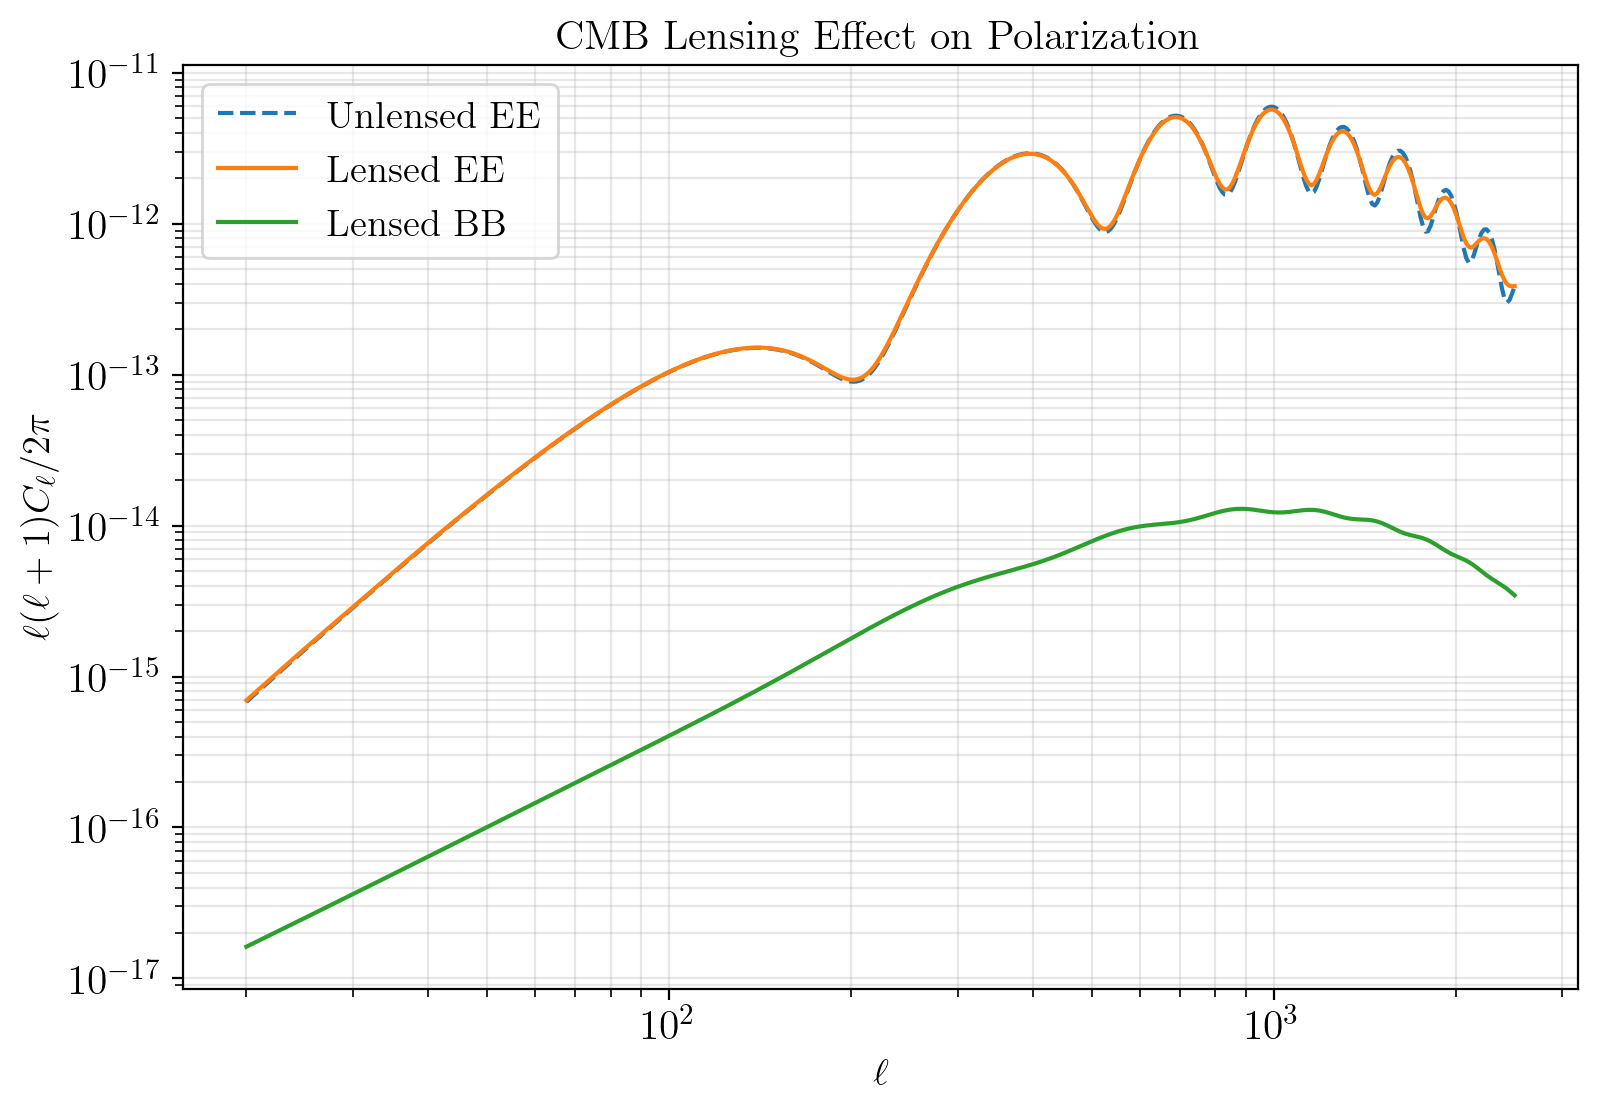

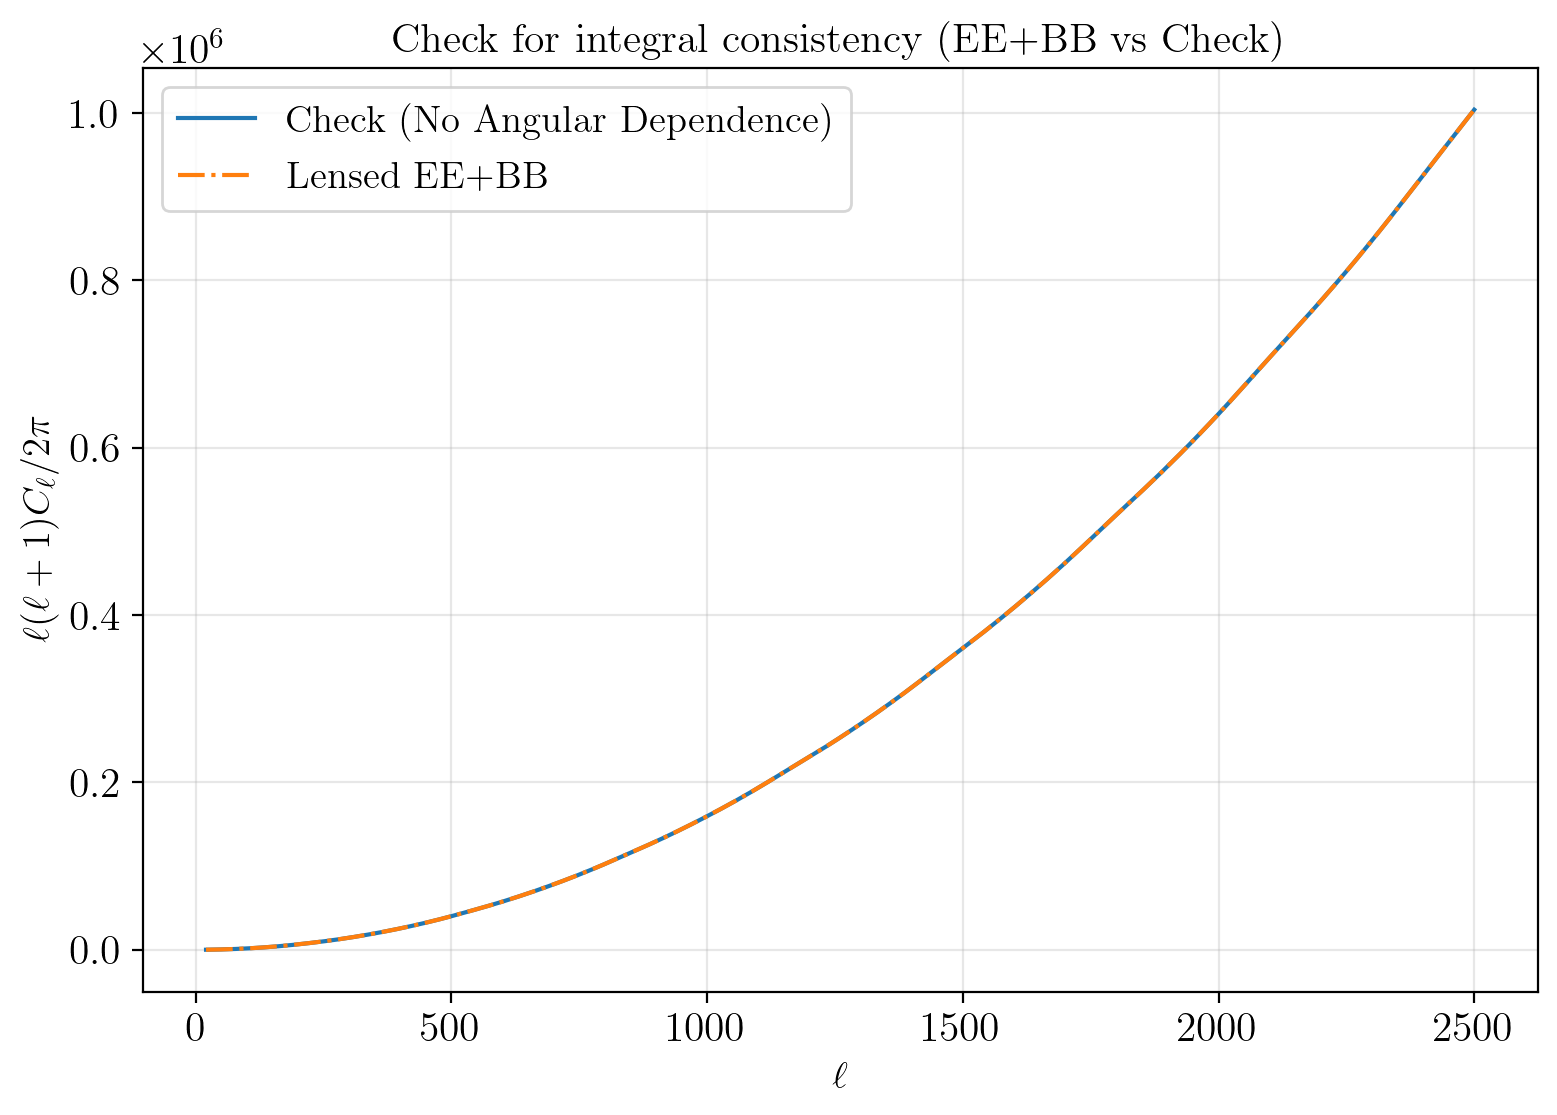

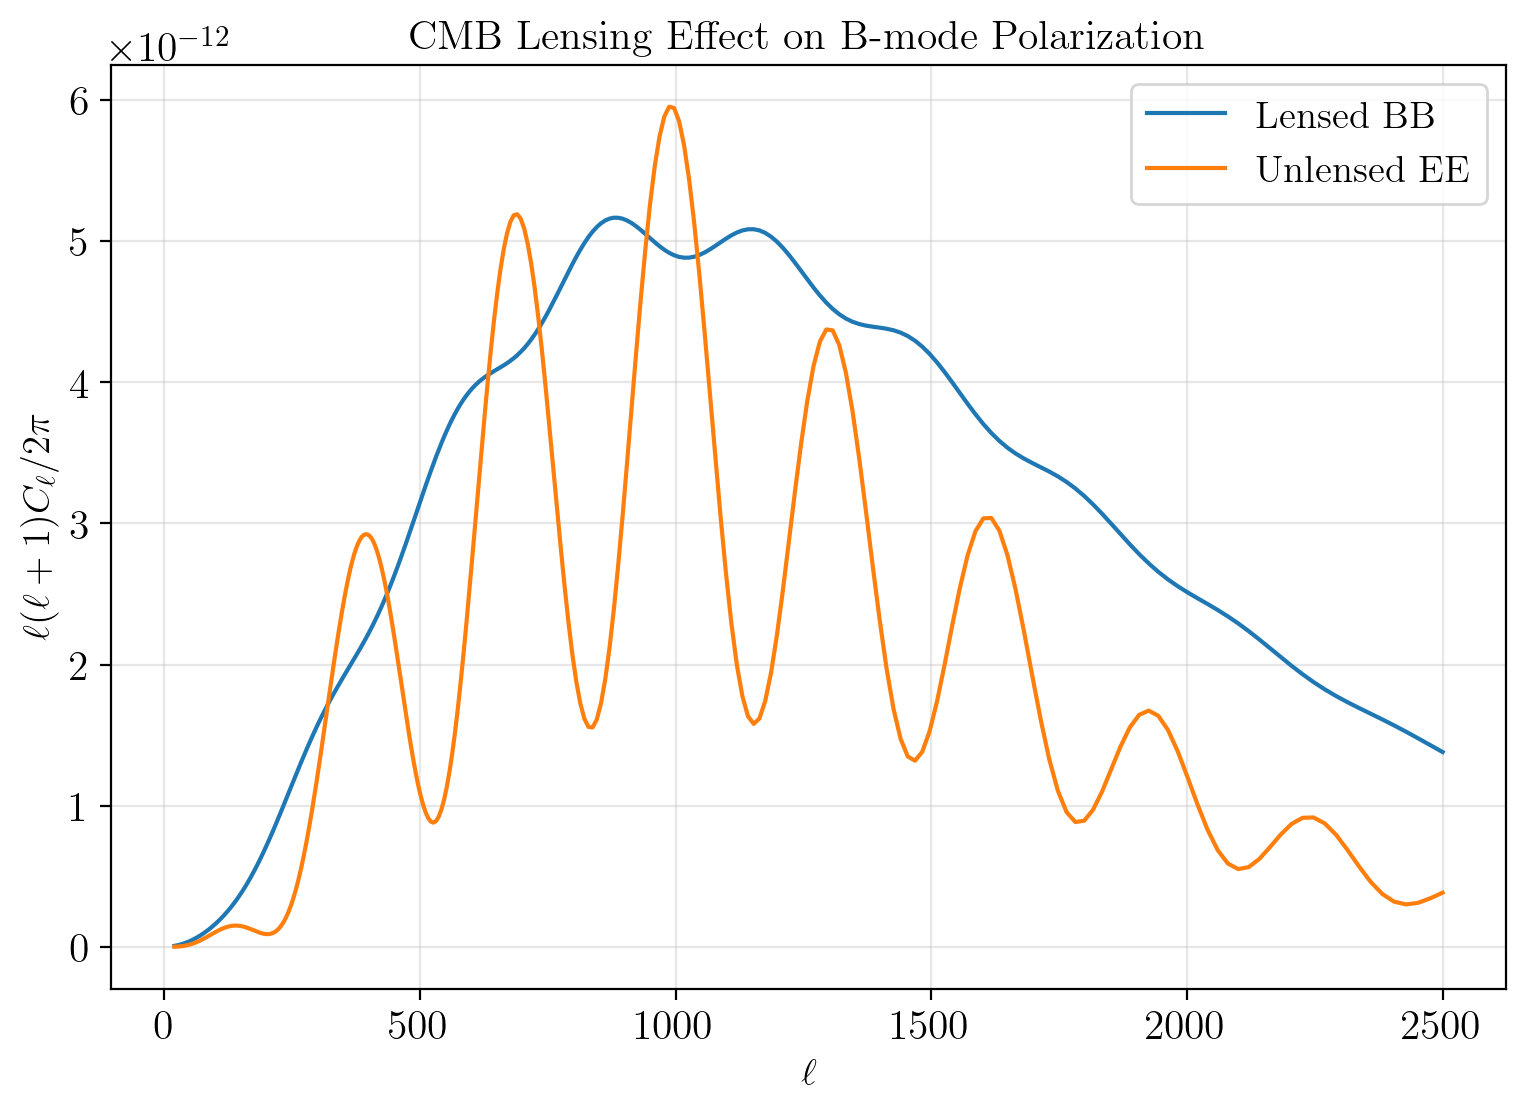

In [11]:
# Plotting

cee_unlensed = np.array(cee_unlensed)
cee_lensed = np.array(cee_lensed)
cbb_lensed = np.array(cbb_lensed)
c_check = np.array(c_check)
scale = l_calc * (l_calc + 1) / (2 * np.pi)

# Spectra
plt.loglog(l_calc, scale * cee_unlensed, '--', label='Unlensed EE')
plt.loglog(l_calc, scale * cee_lensed, '-', label='Lensed EE')
plt.loglog(l_calc, scale * cbb_lensed, '-', label='Lensed BB')
#plt.plot(l_calc, scale * c_check, '-.', label='Check (No Angular Dependence)')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.title('CMB Lensing Effect on Polarization')
plt.legend()
plt.grid(which='both', alpha=0.3)
plt.show()

plt.plot(l_calc, scale * c_check / cee_lensed, label='Check (No Angular Dependence)')
plt.plot(l_calc, scale * (cee_lensed+cbb_lensed) / cee_lensed, '-.', label='Lensed EE+BB')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.title('Check for integral consistency (EE+BB vs Check)')
plt.legend()
plt.grid(which='both', alpha=0.3)
plt.show()

plt.plot(l_calc, 400 * scale * cbb_lensed, label=r'Lensed BB')
plt.plot(l_calc, scale * cee_unlensed, label=r'Unlensed EE')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.title('CMB Lensing Effect on B-mode Polarization')
plt.legend()
plt.grid(which='both', alpha=0.3)
plt.show()